# Scrape Seals

### Currently operable with zdic website

Make sure to add characters to main data store with the add_new_batch script, before trying to scrape their images.

If scraping on characters listed in missing_chars.csv, set retry = True. If scraping on all characters, set retry = False

In [177]:
import csv
import os
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from PIL import Image
import urllib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
from wand.api import library
import wand.color
import wand.image
import time
import sys
import logging
from tqdm import tqdm


dataDir = '/dcs/project/seal-script-project-data/seal-script-new/scraped'
charListPath = './source/CharFreq-Classical.xls'
charsToKeep = 1000
sources = ['https://www.zdic.net/hans/', 
            # 'https://www.cidianwang.com/shuowenjiezi/'
            #'https://hanziyuan.net/#'
            ]
newImageFiletype = 'png'
log = 'scrape.log'
retry = False

formatter = logging.Formatter("[%(asctime)s] [%(levelname)s] %(message)s")
handler = logging.FileHandler(log)
handler.setFormatter(formatter)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(handler)

In [163]:
def generate_image_filename(dataDir, index, filetype):
    ''' Generate filename for new image so that all image files within the class are numbered correctly without incontinuity or overlap '''
    # Find directory of current character
    curr_char_dir = os.path.join(dataDir, str(index))
    # Get list of all objects in directory
    files = os.listdir(curr_char_dir)
    # Keep objects which are files
    files = [f for f in files if os.path.isfile(curr_char_dir+'/'+f) and f'.{filetype}' in f]
    # Get number of files in directory
    curr_image_count = len(files)#str(int(files[-1][files[-1].index('_')+1:files[-1].index('.')])) if not len(files) == 0 else '1'     
    # Generate filename
    newImageFilename = f"{index}_{curr_image_count+1}"
    return newImageFilename

def saveSvgImage(url_list:list, dataDir:str, index:int, filetype:str):
    '''
    Save the SVG images discovered while scraping as <filetype>

        Args:
            url_list - list of urls to SVG images
            dataDir - root folder of character sub-folders
            index - index of character being scraped
            filetype - filetype to save final images
    '''
    for url in range(len(url_list)):
        img_path = 'https:' + url_list[url]
        print(img_path)

        newImageFilename = generate_image_filename(dataDir, index, filetype)
        print(f'Filename for new image is: {newImageFilename}')

        # Retrieve SVG file from url obtained from scraping and save SVG file
        charDir = os.path.join(dataDir, str(index))
        svg_filename, headers = urllib.request.urlretrieve(img_path, os.path.join(charDir, f"{newImageFilename}.svg"))#img_path[img_path.rfind('/')+1:]))
        print(svg_filename)
        new_image_path = os.path.join(charDir, newImageFilename + "." + filetype)

        with open(svg_filename, "r") as f:
            svg_blob = f.read().encode('utf-8')
            with wand.image.Image( blob=svg_blob, format="svg" ) as image:
                png_image = image.make_blob("png")
                fp = io.BytesIO(png_image)
                with fp:
                    
                    img = mpimg.imread(fp, format='png')
                    plt.imshow(img, cmap='gray')
                    plt.axis('off')
                    plt.savefig(new_image_path)

                    fp.close()
                f.close()
            os.remove(svg_filename)

            print(f'Successfully saved new image at {new_image_path}')
        time.sleep(3)

# Get the image url from the site for given character
def get_char_urls(url, char, index):
    url_list = []
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    results = soup.find_all("a", {"href": f"/zd/zx/xz/{char}"})
    for x in results:
        children = x.findChildren("img" , recursive=False)

        # If no images exist for current element, skip to next element 
        if len(children) == 0:
            continue
        
        # Check that image exists for current character, else skip to next element
        span_child = x.findChildren("span", recursive=True)[0]
        if not f"「{char}」" in span_child.text:
            continue

        # Add url of image to list of urls
        for child in children:
            attr = child.attrs['data-original']
            url_list.append(attr)
    if len(url_list) == 0:
        logger.critical(f'(Zdic) Char {char}. No urls found for images')
    
    return url_list        

def scrapeZdic(dataDir:str, scrape_url_base:str, index:int, char:str, filetype:str):
    try:
        print(f"Searching for character {index}: {char}")
        scrape_url = scrape_url_base + char
        print(f"Searching on URL {scrape_url}")

        # Get urls of all seal images for current character
        url_list = get_char_urls(scrape_url, char, index)
        print(url_list)

        # Save each image of the character
        if url_list != None:
            print(f'Found {len(url_list)} images for character')
            saveSvgImage(url_list, dataDir, index, filetype)
        logger.info(f'(Zdic) Char {char} - {str(index)}. Finished scraping')
    except Exception as e:
        logger.critical(f'(Zdic) Char {char}. Failed to obtain with error: {e}')


#####
#
#   CIDIANWANG SHUFA

def stripWatermark(image:Image.Image):
    """Crop the bottom watermark from an image"""
    im = np.array(image)
    h, w = im.shape[:2]
    half = w//2
    twentyfive = w//4
    cropLeft = half - (twentyfive//2)
    cropTop = h - 45  # magic number
    im[cropTop:h, cropLeft:cropLeft+twentyfive+1] = 255

    out = Image.fromarray(im)
    return out


def scrapeCharacter(pageSoup:BeautifulSoup, index:int, dataDir:str, filetype:str):
    """Download individual character pictures from the result page"""
    results = pageSoup.findAll("img", {"class": "lazyload"})
    urls = [result.attrs["data-src"] for result in results]
    print(urls)
    
    headers2 = {
        'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36",
        'Referer': 'https://www.cidianwang.com/',
        "Host": "c.cidianwang.com"
    }
    
    # Generate filename for new image and create path to image
    
    for i, url in tqdm(enumerate(urls)):
        print(url)
        newImageFilename = generate_image_filename(dataDir, index, filetype)
        path = os.path.join(dataDir, str(index))
        path = os.path.join(path, newImageFilename)
        try:
            if not re.findall("zhuanshu", url):  # zhuanshu: seal script
                continue
            print(i, url)
            img = Image.open(requests.get(url, stream=True, headers=headers2).raw)
            img = stripWatermark(img)
            img.save(path + ".png")
        except Exception as e:
            logger.error(e)


def searchShufa(character:str, index:int, dataDir:str, filetype:str):
    """Scrape cidianwang shufa
    
    character: any han character"""
    headers = {
        'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36",
        'Referer': 'https://www.cidianwang.com/'
    }
    
    try:
        url = f"https://search.cidianwang.com/?m=8&q={character}&z=输入书法家&y=4"
        page = requests.get(url, headers=headers)
        soup = BeautifulSoup(page.content, "html.parser")
        scrapeCharacter(soup, index, dataDir, filetype)
        logger.info(f'(Shufa) Char {character} - {str(index)}. Finished scraping')
    except Exception as ex:
        e = sys.exc_info()[0]
        logger.critical(f'(Shufa) Char {character}. Failed to obtain with error: {e}')
        import traceback
        traceback.print_exc(ex)


#####


def setupCharStorage(dataDir:str, charList:list):
    '''
        Make a folder to store images for each character.

        Args:
            dataDir - location to make folders
            charList - list of characters to make folders for
    '''
    for i in range(len(charList)):
        idx = str(charList['idx'].iloc[i])
        if not os.path.exists(os.path.join(dataDir, idx)):
            os.makedirs(os.path.join(dataDir, idx))


In [179]:
### MAIN FUNCTION FOR SCRAPING
def main(charListPath:str, dataDir:str, charsToKeep:int, sources:list):
    # Read excel file
    xls_content = pd.read_excel(charListPath)
    # Grab desired columns and number of chars
    charList = xls_content[['Unnamed: 0', 'Unnamed: 1']].iloc[1:charsToKeep+1]
    # Rename columnds
    charList.columns = ['idx', 'char']
    # Save char list to csv file
    charList.to_csv('./classical_chars.csv', index=False, header=False)
    
    # Create folder structure for storing character images
    setupCharStorage(dataDir, charList)

    # Scrape Zdic
    source = sources[0]
    for i, (idx, char) in charList.iterrows():
        print(i)
        if i==2:
            break
        scrapeZdic(dataDir, source, idx, char, newImageFiletype)

    # Scrape Shufa
    for i, (idx, char) in charList.iterrows():
        print(i)
        if i==2:
            break
        searchShufa(char, idx, dataDir, newImageFiletype)


1
Searching for character 1: 之
Searching on URL https://www.zdic.net/hans/之
[<a href="/zd/zx/xz/之"><img class="lazy ypic" data-original="//img.zdic.net/zy/xiaozhuan/27_4E4B.svg"/><span>「之」 說文‧之部</span></a>, <a href="/zd/zx/xz/之">說文小篆</a>]
<a href="/zd/zx/xz/之"><img class="lazy ypic" data-original="//img.zdic.net/zy/xiaozhuan/27_4E4B.svg"/><span>「之」 說文‧之部</span></a>
[<img class="lazy ypic" data-original="//img.zdic.net/zy/xiaozhuan/27_4E4B.svg"/>]
「之」 說文‧之部
True
<a href="/zd/zx/xz/之">說文小篆</a>
[]
['//img.zdic.net/zy/xiaozhuan/27_4E4B.svg']
Found 1 images for character
https://img.zdic.net/zy/xiaozhuan/27_4E4B.svg
Filename for new image is: 1_1
/dcs/project/seal-script-project-data/seal-script-new/scraped/1/1_1.svg
Successfully saved new image at /dcs/project/seal-script-project-data/seal-script-new/scraped/1/1_1.png
[2024-04-16 00:43:08,046] [INFO] (Zdic) Char 之 - 1. Finished scraping
[2024-04-16 00:43:08,046] [INFO] (Zdic) Char 之 - 1. Finished scraping
[2024-04-16 00:43:08,046] [INFO] (

0it [00:00, ?it/s]

https://c.cidianwang.com/file/shufa/zhuanshu/2021106124052bc0dd.jpg
0 https://c.cidianwang.com/file/shufa/zhuanshu/2021106124052bc0dd.jpg


1it [00:01,  1.22s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/2021106124052ac0d4.jpg
1 https://c.cidianwang.com/file/shufa/zhuanshu/2021106124052ac0d4.jpg


2it [00:02,  1.18s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/2021106122235073de.jpg
2 https://c.cidianwang.com/file/shufa/zhuanshu/2021106122235073de.jpg


3it [00:03,  1.15s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/20211061212263c1c4.jpg
3 https://c.cidianwang.com/file/shufa/zhuanshu/20211061212263c1c4.jpg


4it [00:04,  1.05s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/202110612122674be1.jpg
4 https://c.cidianwang.com/file/shufa/zhuanshu/202110612122674be1.jpg


5it [00:05,  1.01it/s]

https://c.cidianwang.com/file/shufa/zhuanshu/2019121794240f05d1.jpg
5 https://c.cidianwang.com/file/shufa/zhuanshu/2019121794240f05d1.jpg


6it [00:06,  1.03s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/201912162136617e31.jpg
6 https://c.cidianwang.com/file/shufa/zhuanshu/201912162136617e31.jpg


7it [00:07,  1.05s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/dengshiru/20197251411202bb3e.jpg
7 https://c.cidianwang.com/file/shufa/zhuanshu/dengshiru/20197251411202bb3e.jpg


8it [00:08,  1.07s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/ligangtian/201972592934dac9f.jpg
8 https://c.cidianwang.com/file/shufa/zhuanshu/ligangtian/201972592934dac9f.jpg


9it [00:09,  1.08s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/laichusheng/20197259254743531.jpg
9 https://c.cidianwang.com/file/shufa/zhuanshu/laichusheng/20197259254743531.jpg


10it [00:10,  1.11s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/20188418334fde3c.jpg
10 https://c.cidianwang.com/file/shufa/zhuanshu/20188418334fde3c.jpg


11it [00:12,  1.13s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/20188418334a9ec3.jpg
11 https://c.cidianwang.com/file/shufa/zhuanshu/20188418334a9ec3.jpg


12it [00:13,  1.14s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/201884183341f871.jpg
12 https://c.cidianwang.com/file/shufa/zhuanshu/201884183341f871.jpg


13it [00:14,  1.14s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/201884182935c2be5.jpg
13 https://c.cidianwang.com/file/shufa/zhuanshu/201884182935c2be5.jpg


14it [00:15,  1.12s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/20183221144612576.jpg
14 https://c.cidianwang.com/file/shufa/zhuanshu/20183221144612576.jpg


15it [00:16,  1.11s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/hantianheng/2017424175735f0a3a.jpg
15 https://c.cidianwang.com/file/shufa/zhuanshu/hantianheng/2017424175735f0a3a.jpg


16it [00:17,  1.11s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/liyangbing/2017122183412bee3.jpg
16 https://c.cidianwang.com/file/shufa/zhuanshu/liyangbing/2017122183412bee3.jpg


17it [00:18,  1.11s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/dengshiru/201692516374941124.jpg
17 https://c.cidianwang.com/file/shufa/zhuanshu/dengshiru/201692516374941124.jpg


18it [00:19,  1.10s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/dengshiru/2016925163358a2c26.jpg
18 https://c.cidianwang.com/file/shufa/zhuanshu/dengshiru/2016925163358a2c26.jpg


19it [00:20,  1.08s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/2016925162321dce79.jpg
19 https://c.cidianwang.com/file/shufa/zhuanshu/2016925162321dce79.jpg


20it [00:21,  1.08s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/fangquji/20169251613446ec9c.jpg
20 https://c.cidianwang.com/file/shufa/zhuanshu/fangquji/20169251613446ec9c.jpg


21it [00:22,  1.09s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/c296a7c70eb3aeea.gif
21 https://c.cidianwang.com/file/shufa/zhuanshu/c296a7c70eb3aeea.gif


22it [00:24,  1.08s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/bff4dc5ea1131722.gif
22 https://c.cidianwang.com/file/shufa/zhuanshu/bff4dc5ea1131722.gif


23it [00:25,  1.07s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/28ce45ab1432967a.gif
23 https://c.cidianwang.com/file/shufa/zhuanshu/28ce45ab1432967a.gif


24it [00:26,  1.07s/it]

https://c.cidianwang.com/file/shufa/zhuanshu/201692516242610aeb.jpg
24 https://c.cidianwang.com/file/shufa/zhuanshu/201692516242610aeb.jpg


25it [00:27,  1.09s/it]

https://c.cidianwang.com/file/shufa/xingshu/2014111117071540.jpg
https://c.cidianwang.com/file/shufa/zhuanshu/201832211450faa70.jpg
26 https://c.cidianwang.com/file/shufa/zhuanshu/201832211450faa70.jpg


27it [00:28,  1.20it/s]

https://c.cidianwang.com/file/shufa/caoshu/40c718db3d5cd26c.gif
https://c.cidianwang.com/file/shufa/zhuanshu/201692516243a704b.jpg
28 https://c.cidianwang.com/file/shufa/zhuanshu/201692516243a704b.jpg


29it [00:29,  1.39it/s]

https://c.cidianwang.com/file/shufa/xingshu/tangyin/2018323113134dba8.jpg
https://c.cidianwang.com/file/shufa/xingshu/2014111010384268.jpg
https://c.cidianwang.com/file/shufa/xingshu/wenzhengming/202110816341923ac.jpg
https://c.cidianwang.com/file/shufa/xingshu/2014123120442054.jpg
https://c.cidianwang.com/file/shufa/xingshu/2015011215353357.jpg
https://c.cidianwang.com/file/shufa/xingshu/huangtingjian/2018841946170e439.jpg
https://c.cidianwang.com/file/shufa2/lishu/2/1064407592.gif
https://c.cidianwang.com/file/shufa/zhuanshu/20169251623134f6be.jpg
36 https://c.cidianwang.com/file/shufa/zhuanshu/20169251623134f6be.jpg


37it [00:30,  3.17it/s]

https://c.cidianwang.com/file/shufa/kaishu/hzy2015816142643862.jpg
https://c.cidianwang.com/file/shufa/xingshu/dongqichang/201972512282588588.jpg
https://c.cidianwang.com/file/shufa/xingshu/beike/2021108101033c2449.jpg
https://c.cidianwang.com/file/shufa/zhuanshu/20169251622599c526.jpg
40 https://c.cidianwang.com/file/shufa/zhuanshu/20169251622599c526.jpg


44it [00:31,  1.39it/s]

https://c.cidianwang.com/file/shufa/xingshu/a/20211089134997cf7.jpg
https://c.cidianwang.com/file/shufa/lishu/5a421e6eb8851313.gif
https://c.cidianwang.com/file/shufa/xingshu/beike/20211081010228250d.jpg
[2024-04-16 00:43:42,450] [INFO] (Shufa) Char 之 - 1. Finished scraping
[2024-04-16 00:43:42,450] [INFO] (Shufa) Char 之 - 1. Finished scraping
[2024-04-16 00:43:42,450] [INFO] (Shufa) Char 之 - 1. Finished scraping
2


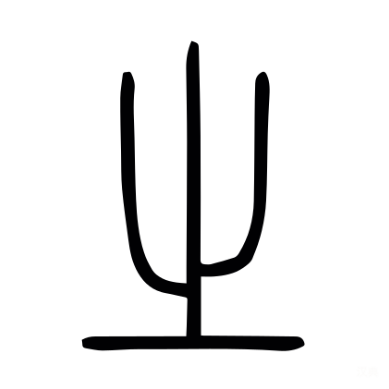

In [180]:
main(charListPath=charListPath, dataDir=dataDir, charsToKeep=charsToKeep, sources=sources)